# Hungary Weather

This [Kaggle Dataset](https://www.kaggle.com/budincsevity/szeged-weather) contains weather data for Szeged, Hungary from 2006 to 2016.

The goal is to answer the following questions:
1. What is the average temperature, humidity, and wind speed?
2. How has weather changed over time?
3. Can temperature be forecasted?

In [1]:
# Import libraries
import pandas as pd
import numpy as np

# visualization
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

plt.style.use("sg")
%matplotlib inline

%load_ext nb_black

<IPython.core.display.Javascript object>

In [212]:
# Read data
df = pd.read_csv("weatherHistory.csv")
df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


<IPython.core.display.Javascript object>

In [213]:
# Rename columns
df.columns = [name.lower().replace(" ", "_").split("_(")[0] for name in df.columns]

<IPython.core.display.Javascript object>

In [214]:
# Format to datetime
df["formatted_date"] = pd.to_datetime(df["formatted_date"], utc=True)

# Get date, hour
df["date"] = df.formatted_date.apply(lambda x: x.date)
df["hour"] = df.formatted_date.apply(lambda x: x.hour)
df["month"] = df.date.apply(lambda x: x.replace(day=1))
df["year"] = df.formatted_date.apply(lambda x: x.year)

<IPython.core.display.Javascript object>

In [215]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   formatted_date        96453 non-null  datetime64[ns, UTC]
 1   summary               96453 non-null  object             
 2   precip_type           95936 non-null  object             
 3   temperature           96453 non-null  float64            
 4   apparent_temperature  96453 non-null  float64            
 5   humidity              96453 non-null  float64            
 6   wind_speed            96453 non-null  float64            
 7   wind_bearing          96453 non-null  float64            
 8   visibility            96453 non-null  float64            
 9   loud_cover            96453 non-null  float64            
 10  pressure              96453 non-null  float64            
 11  daily_summary         96453 non-null  object             
 12  date

<IPython.core.display.Javascript object>

`precip_type` has some null values, but we can try to fill it in based on different features.

In [216]:
# See if we can determine precip_type by temperature
df.groupby("precip_type").agg({"temperature": ["mean", "min", "max", "std"]})

temperature                                
                   mean        min        max       std
precip_type                                            
rain          13.852989   0.005556  39.905556  8.317505
snow          -3.270885 -21.822222   0.000000  3.075312

<IPython.core.display.Javascript object>

We can definitely tell if the `precip_type` is snow if the temperature is under 0 degrees Celsius.

In [217]:
def determine_precip(temperature):
    """
    Determine precipitation type based on temperature 
    """
    if temperature <= 0:
        return "snow"
    return "rain"


df["precip_type"] = df.temperature.apply(lambda x: determine_precip(x))

<IPython.core.display.Javascript object>

## Exploratory

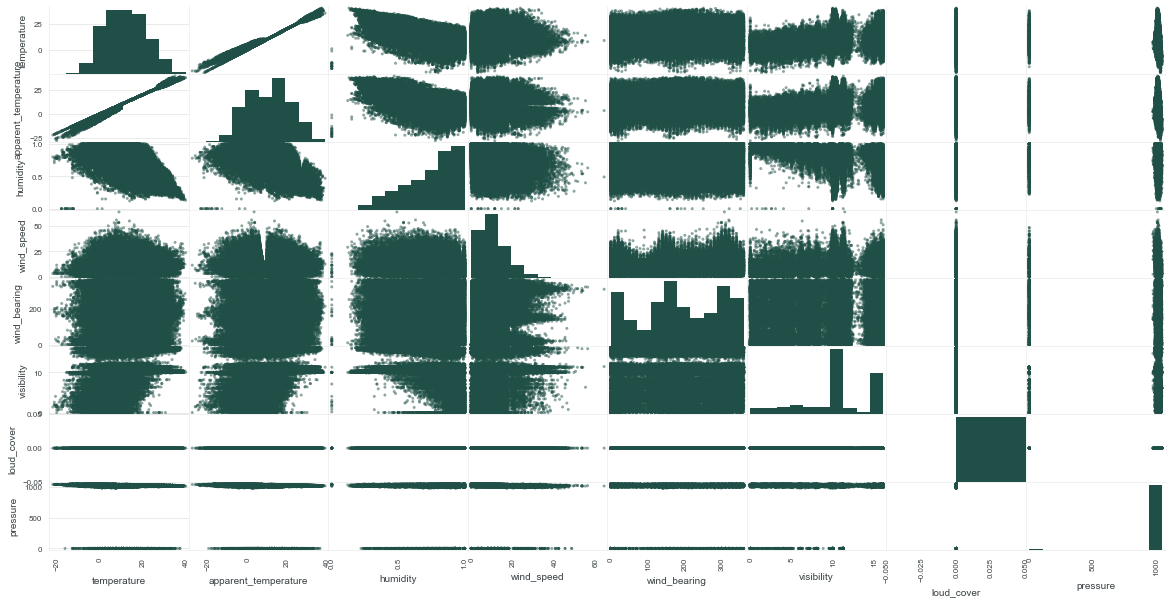

<IPython.core.display.Javascript object>

In [29]:
# Plot scatter matrix for correlations
scatter_matrix(df.iloc[:, 3:], figsize=[20, 10], alpha=.1)

### What is the average temperature, humidity, and wind speed?

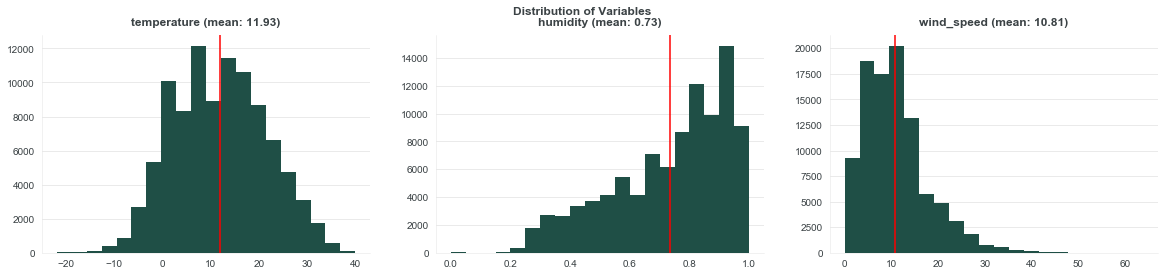

<IPython.core.display.Javascript object>

In [90]:
variables = ["temperature", "humidity", "wind_speed"]

fig, axes = plt.subplots(1, 3, figsize=[20, 4])
fig.suptitle("Distribution of Variables")

for index, v in enumerate(variables):

    ax = axes[index]
    m = df[v].mean()

    ax.set_title(f"{v} (mean: {round(m, 2)})")
    ax.hist(x=df[v], bins=20)
    ax.axvline(x=m, color="red")

### How has weather changed over time?

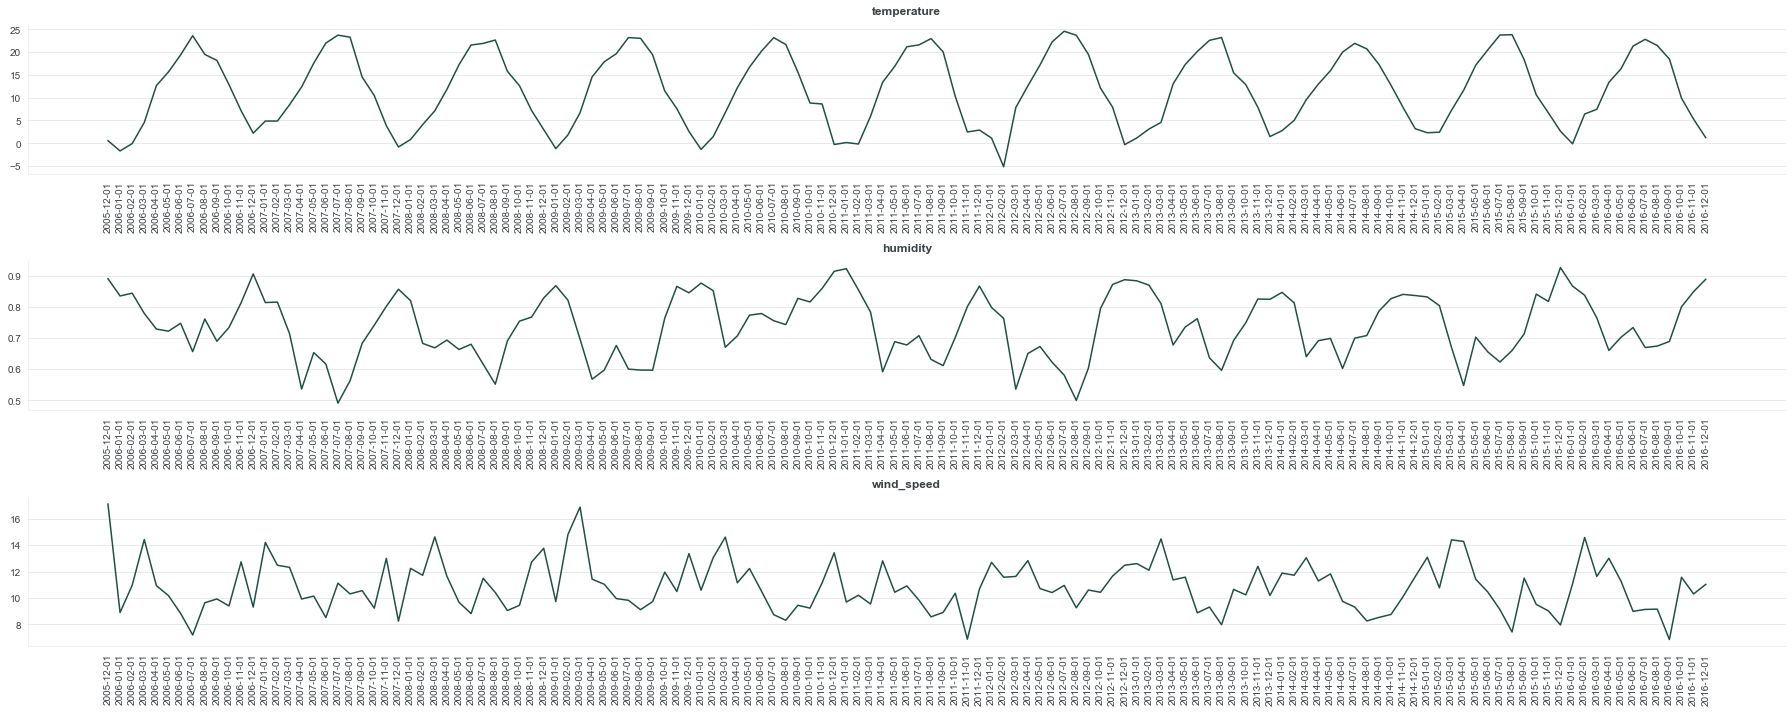

<IPython.core.display.Javascript object>

In [109]:
variables = ["temperature", "humidity", "wind_speed"]

fig, axes = plt.subplots(3, 1, figsize=[25, 10])

for index, v in enumerate(variables):

    ax = axes[index]
    p = df.groupby("month").mean()[v].reset_index().sort_values(by="month")

    ax.set_title(v)
    ax.plot(p["month"].astype("str"), p[v])

    for tick in ax.get_xticklabels():
        tick.set_rotation(90)

fig.tight_layout()

* Temperature definitely has seasonal trends with a ~25 C difference between summers and winters
* Humidity is higher when the temperature is cooler (see correlation chart)
* Wind speed has the least correlation

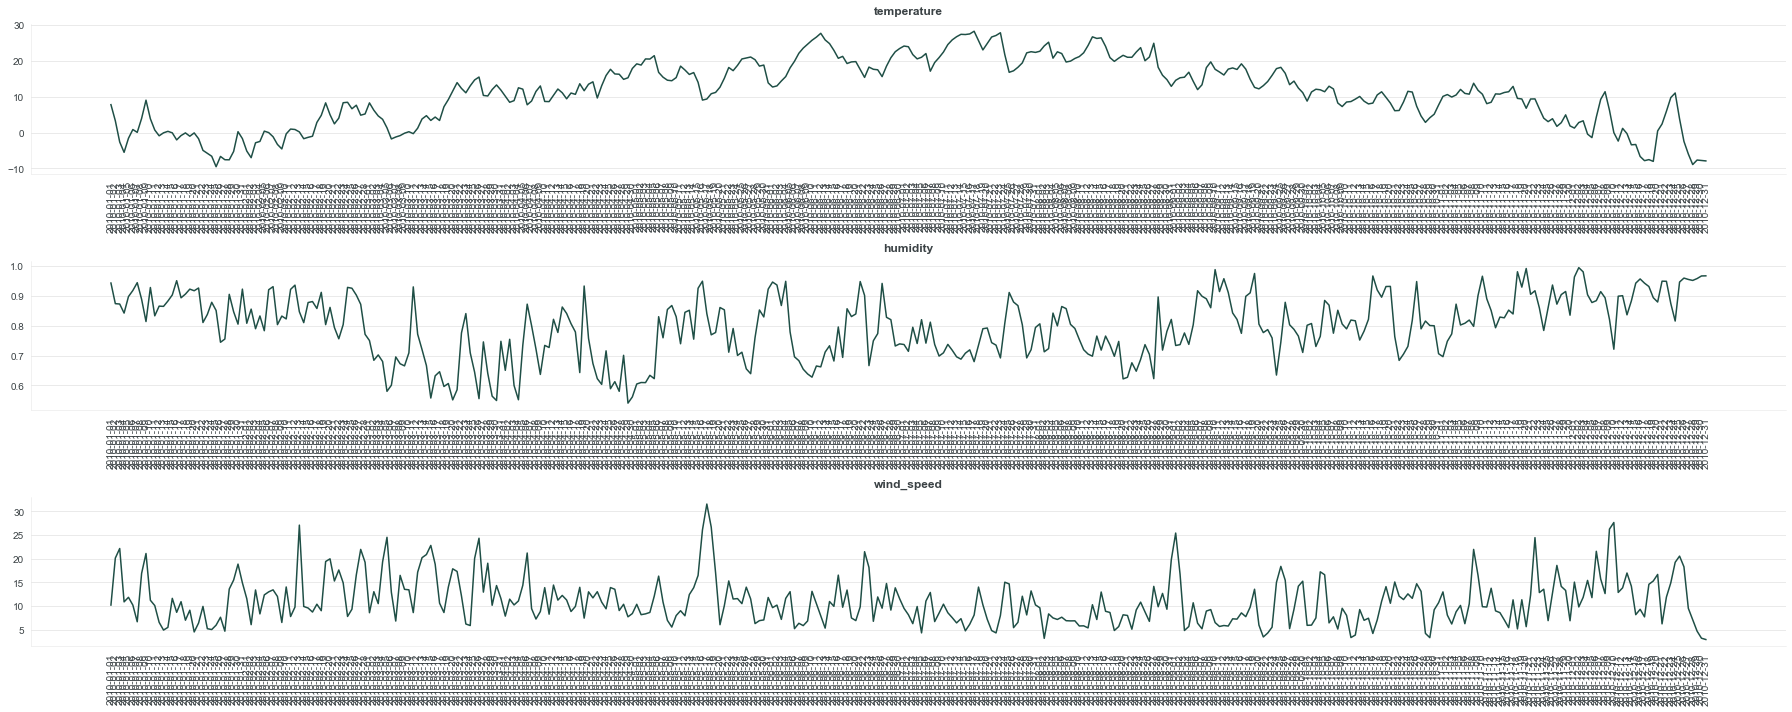

<IPython.core.display.Javascript object>

In [115]:
# . View daily for 1 year
variables = ["temperature", "humidity", "wind_speed"]

fig, axes = plt.subplots(3, 1, figsize=[25, 10])

for index, v in enumerate(variables):

    ax = axes[index]
    p = (
        df[df.year == 2010]
        .groupby("date")
        .mean()[v]
        .reset_index()
        .sort_values(by="date")
    )

    ax.set_title(v)
    ax.plot(p["date"].astype("str"), p[v])

    for tick in ax.get_xticklabels():
        tick.set_rotation(90)

fig.tight_layout()

### Can temperature be forecasted?

The data provided is on an hourly level, but I will forecast **the most recent year** on a daily level before attempting to forecast on an hourly level.

In [218]:
# Create a dataframe on daily level
df_daily = df.groupby("date").mean().drop(columns=["hour"]).sort_index()
df_daily.drop(columns=["year", "apparent_temperature"], inplace=True)
df_daily.head(1)

,temperature,humidity,wind_speed,wind_bearing,visibility,loud_cover,pressure
date,,,,,,,
2005-12-31,0.577778,0.89,17.1143,140.0,9.982,0.0,1016.66


<IPython.core.display.Javascript object>

In [219]:
# Create yesterday's values
df_daily["yesterday_1_temperature"] = df_daily["temperature"].shift()
df_daily["yesterday_1_temperature_diff"] = df_daily[
    "yesterday_1_temperature"
].diff()  # day before yesterday - yesterday

# Create day before yesterday's values
df_daily["yesterday_2_temperature"] = df_daily["yesterday_1_temperature"].shift()
df_daily["yesterday_2_temperature_diff"] = df_daily[
    "yesterday_2_temperature"
].diff()  # 3 days ago - 2 days ago

df_daily.dropna(inplace=True)
df_daily.head()

,temperature,humidity,wind_speed,wind_bearing,visibility,loud_cover,pressure,yesterday_1_temperature,yesterday_1_temperature_diff,yesterday_2_temperature,yesterday_2_temperature_diff
date,,,,,,,,,,,
2006-01-03,2.340509,0.897083,7.726658,252.541667,9.223958,0.0,1021.170833,5.263194,1.188194,4.075000,3.497222
2006-01-04,2.251852,0.906667,12.152817,35.000000,8.352546,0.0,981.770833,2.340509,-2.922685,5.263194,1.188194
2006-01-05,2.703935,0.951250,8.991179,139.875000,4.308092,0.0,935.873750,2.251852,-0.088657,2.340509,-2.922685
2006-01-06,2.550463,0.945833,5.729588,269.500000,4.635458,0.0,1023.645833,2.703935,0.452083,2.251852,-0.088657
2006-01-07,0.877083,0.935833,6.589596,102.041667,4.585817,0.0,1030.223750,2.550463,-0.153472,2.703935,0.452083


<IPython.core.display.Javascript object>

In [220]:
df_daily.index = df_daily.index.astype("str")

<IPython.core.display.Javascript object>

In [221]:
# Create train and test datasets
x_train = df_daily.loc[:"2016"].drop(["temperature"], axis=1)
y_train = df_daily.loc[:"2016", "temperature"]

x_test = df_daily.loc["2016":].drop(["temperature"], axis=1)
y_test = df_daily.loc["2016":, "temperature"]

<IPython.core.display.Javascript object>

In [222]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import sklearn.metrics as metrics

<IPython.core.display.Javascript object>

LR: 0.944899 (0.007937)
KNN: 0.831195 (0.082663)
RF: 0.941460 (0.011612)


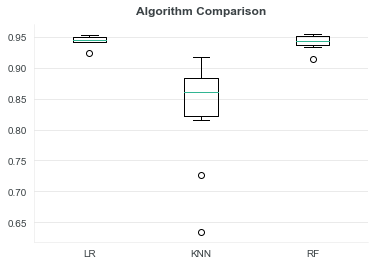

<IPython.core.display.Javascript object>

In [223]:
# Try different models

models = []
models.append(("LR", LinearRegression()))
models.append(("KNN", KNeighborsRegressor()))
models.append(("RF", RandomForestRegressor(n_estimators=10)))

results = []
names = []

for name, model in models:

    # Time Series Cross validation (forward chaining)
    tscv = TimeSeriesSplit(n_splits=10)  # Use 10 for the 10 years in training set

    cv_results = cross_val_score(model, x_train, y_train, cv=tscv, scoring="r2")
    results.append(cv_results)
    names.append(name)
    print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))

# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title("Algorithm Comparison")
plt.show()

Linear Regression and RF performed very well with the training data. Linear Regression has a slightly better R^2.

In [224]:
def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    print("explained_variance: ", round(explained_variance, 4))
    print("r2: ", round(r2, 4))
    print("MAE: ", round(mean_absolute_error, 4))
    print("MSE: ", round(mse, 4))
    print("RMSE: ", round(np.sqrt(mse), 4))

<IPython.core.display.Javascript object>

In [225]:
model = LinearRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
regression_results(y_test, y_pred)

explained_variance:  0.9525
r2:  0.9523
MAE:  1.2909
MSE:  3.2797
RMSE:  1.811


<IPython.core.display.Javascript object>

:D 

Now try forecasting on hour...

In [238]:
df = pd.read_csv("weatherHistory.csv", index_col=0)
df.columns = [name.lower().replace(" ", "_").split("_(")[0] for name in df.columns]
df.drop(
    columns=["summary", "precip_type", "daily_summary", "apparent_temperature"],
    inplace=True,
)
df.sort_index(inplace=True)

<IPython.core.display.Javascript object>

In [239]:
# Create yesterday's values
df["yesterday_1_temperature"] = df["temperature"].shift(periods=24)
df["yesterday_1_temperature_diff"] = df[
    "yesterday_1_temperature"
].diff()  # day before yesterday - yesterday

df.dropna(inplace=True)
df.head()

,temperature,humidity,wind_speed,wind_bearing,visibility,loud_cover,pressure,yesterday_1_temperature,yesterday_1_temperature_diff
Formatted Date,,,,,,,,,
2006-01-02 01:00:00.000 +0100,2.350000,0.91,15.2950,221.0,5.3130,0.0,1014.72,1.161111,0.583333
2006-01-02 02:00:00.000 +0100,5.422222,0.80,16.8245,147.0,15.5526,0.0,1009.10,1.666667,0.505556
2006-01-02 03:00:00.000 +0100,5.905556,0.80,19.5615,147.0,15.5526,0.0,1008.91,1.711111,0.044444
2006-01-02 04:00:00.000 +0100,5.966667,0.80,19.1268,137.0,14.7637,0.0,1008.52,1.183333,-0.527778
2006-01-02 05:00:00.000 +0100,5.950000,0.77,23.0552,138.0,10.9802,0.0,1008.00,1.205556,0.022222


<IPython.core.display.Javascript object>

In [240]:
# Create train and test datasets
x_train = df.loc[:"2016"].drop(["temperature"], axis=1)
y_train = df.loc[:"2016", "temperature"]

x_test = df.loc["2016":].drop(["temperature"], axis=1)
y_test = df.loc["2016":, "temperature"]

<IPython.core.display.Javascript object>

LR: 0.907392 (0.010103)
KNN: 0.869877 (0.020167)
RF: 0.910382 (0.014513)


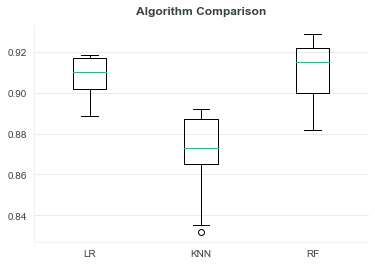

<IPython.core.display.Javascript object>

In [241]:
# Try different models

models = []
models.append(("LR", LinearRegression()))
models.append(("KNN", KNeighborsRegressor()))
models.append(("RF", RandomForestRegressor(n_estimators=10)))

results = []
names = []

for name, model in models:

    # Time Series Cross validation (forward chaining)
    tscv = TimeSeriesSplit(n_splits=10)  # Use 10 for the 10 years in training set

    cv_results = cross_val_score(model, x_train, y_train, cv=tscv, scoring="r2")
    results.append(cv_results)
    names.append(name)
    print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))

# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title("Algorithm Comparison")
plt.show()

Random Forest performs the best out of all the models, although they all perform well in general (maybe random forest was the better model on the daily level too).

In [242]:
model = RandomForestRegressor()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
regression_results(y_test, y_pred)

explained_variance:  0.9203
r2:  0.9203
MAE:  2.016
MSE:  6.4988
RMSE:  2.5493


<IPython.core.display.Javascript object>

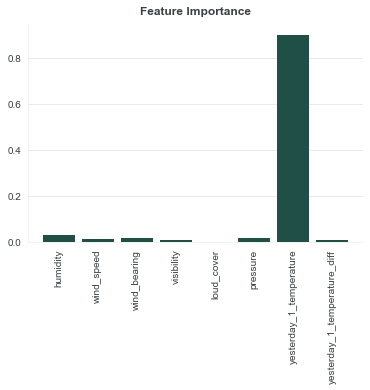

<IPython.core.display.Javascript object>

In [243]:
fig, ax = plt.subplots()
ax.set_title("Feature Importance")
ax.bar(x=x_train.columns, height=model.feature_importances_)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

plt.show()

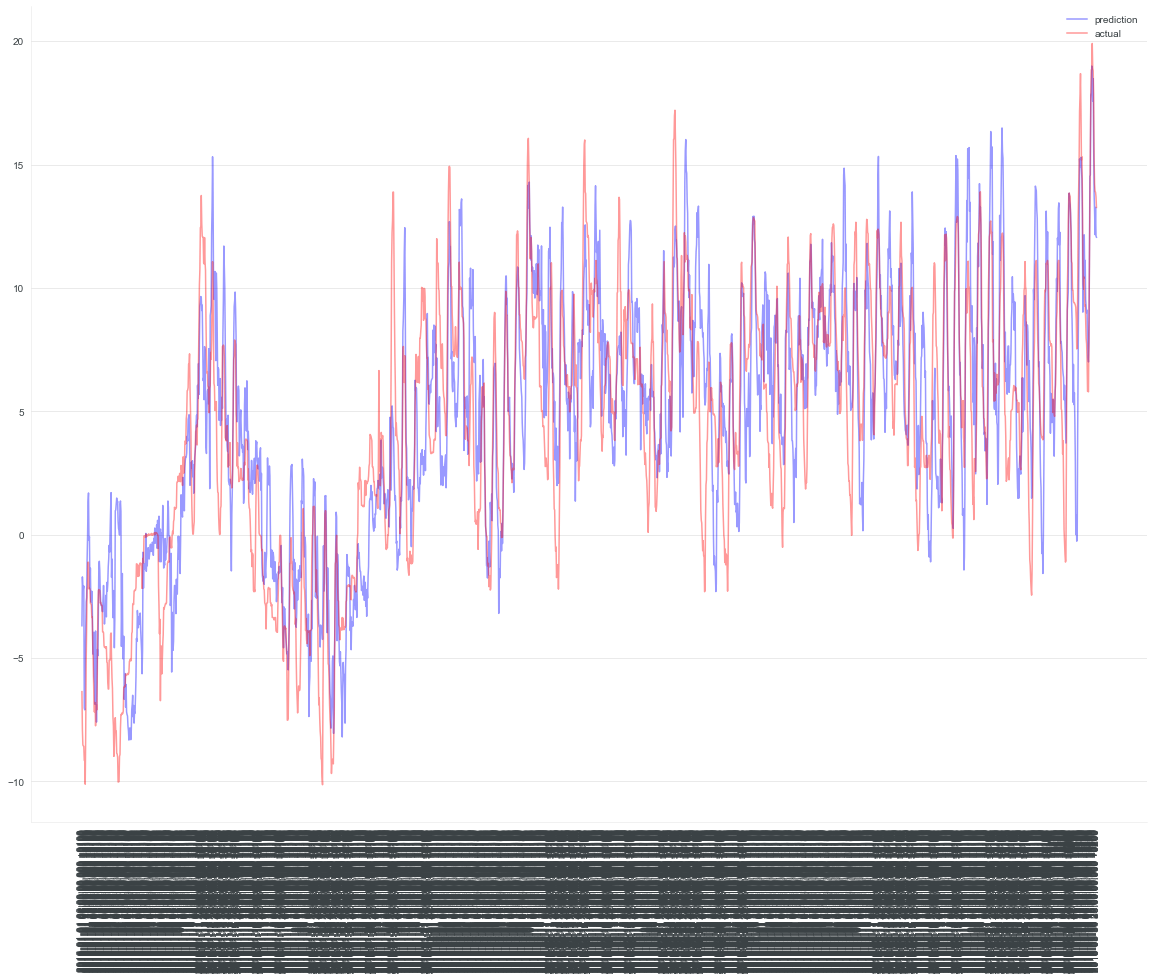

<IPython.core.display.Javascript object>

In [244]:
fig, ax = plt.subplots(figsize=[20, 15])

x = pd.Series(x_test.index[: 24 * 90])
y1 = pd.Series(y_pred[: 24 * 90])
y2 = pd.Series(y_test[: 24 * 90])
ax.plot(x, y1, color="b", label="prediction", alpha=0.4)
ax.plot(x, y2, color="r", label="actual", alpha=0.4)

for tick in ax.get_xticklabels():
    tick.set_rotation(90)

ax.legend()

plt.show()